In [ ]:
import pandas as pd
# Load results
df_regex = pd.read_csv('../results/nova_logs_with_regex.csv')
df_bert = pd.read_csv('../results/nova_logs_with_bert.csv')
df_llm = pd.read_csv('../results/strategic_1k_with_llm_results.csv')

# Merge: start with all unique log_ids
all_log_ids = pd.Series(
    list(set(df_regex['log_id']) | set(df_bert['log_id']) | set(df_llm['log_id'])),
    name='log_id'
)
df = pd.DataFrame(all_log_ids)
df = df.merge(df_regex[['log_id', 'regex_label']], on='log_id', how='left')
df = df.merge(df_bert[['log_id', 'bert_label', 'bert_confidence']], on='log_id', how='left')
df = df.merge(df_llm[['log_id', 'llm_category', 'llm_confidence', 'llm_reasoning']], on='log_id', how='left')


In [2]:
def assign_final(row):
    if pd.notnull(row['regex_label']) and str(row['regex_label']).strip() != "":
        return row['regex_label'], 1.0, 'Regex'
    elif pd.notnull(row['bert_label']) and str(row['bert_label']).strip() != "":
        return row['bert_label'], row.get('bert_confidence', 0.0), 'BERT'
    elif pd.notnull(row['llm_category']) and str(row['llm_category']).strip() != "":
        return row['llm_category'], row.get('llm_confidence', 0.0), 'LLM'
    else:
        return 'Unclassified', 0.0, 'None'

df[['final_category', 'final_confidence', 'pipeline_stage']] = df.apply(assign_final, axis=1, result_type='expand')


In [ ]:
# Drop all rows where final_category is 'Unclassified'
new_df = df[df['final_category'] != 'Unclassified'].copy()

# Optional: Reset index for cleanliness
new_df.reset_index(drop=True, inplace=True)

# Save the cleaned, unified results
new_df.to_csv('../results/hybrid_pipeline_integrated_results.csv', index=False)
print(f"Saved classified-only results: {len(new_df)} logs")


Saved classified-only results: 94749 logs


In [ ]:
new_df.to_csv('../results/hybrid_pipeline_integrated_results.csv', index=False)
print("Integrated results saved")


Integrated results saved


In [5]:
print("\nPipeline Stage Distribution:")
print(new_df['pipeline_stage'].value_counts())

print("\nTop 10 Final Categories:")
print(new_df['final_category'].value_counts().head(10))



Pipeline Stage Distribution:
pipeline_stage
Regex    65975
BERT     21642
LLM       7132
Name: count, dtype: int64

Top 10 Final Categories:
final_category
Instance_Management_Compute    47723
System_Operations_LibVirt      18252
Network_Operations             16058
Scheduler_Operations            6762
Resource_Management             1227
System_Operations               1150
Boot_Timeout_Errors             1067
Instance_Management              781
Network_Connection_Errors        446
Processing_Error                 431
Name: count, dtype: int64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your classified-only results
df_classified = pd.read_csv('../results/hybrid_pipeline_integrated_results.csv')
df_classified.sample(10)


,log_id,regex_label,bert_label,bert_confidence,llm_category,llm_confidence,llm_reasoning,final_category,final_confidence,pipeline_stage
17038,2557,Instance_Management_Compute,NaN,0.646591,NaN,NaN,NaN,Instance_Management_Compute,1.000000,Regex
9222,886,NaN,Scheduler_Operations,0.730250,NaN,NaN,NaN,Scheduler_Operations,0.730250,BERT
58607,11941,Instance_Management_Compute,Network_Operations,0.790260,NaN,NaN,NaN,Instance_Management_Compute,1.000000,Regex
86020,42291,NaN,Network_Operations,0.790446,NaN,NaN,NaN,Network_Operations,0.790446,BERT
42600,8200,NaN,Network_Operations,0.795353,NaN,NaN,NaN,Network_Operations,0.795353,BERT
10955,1168,NaN,Network_Operations,0.717591,NaN,NaN,NaN,Network_Operations,0.717591,BERT
70208,16962,System_Operations_LibVirt,NaN,NaN,NaN,NaN,NaN,System_Operations_LibVirt,1.000000,Regex
25076,4472,Instance_Management_Compute,Network_Operations,0.792198,NaN,NaN,NaN,Instance_Management_Compute,1.000000,Regex
8432,799,Instance_Management_Compute,Scheduler_Operations,0.732573,Resource_Management,0.9,instance deletion,Instance_Management_Compute,1.000000,Regex
27908,4994,System_Operations_LibVirt,System_Operations,0.734734,NaN,NaN,NaN,System_Operations_LibVirt,1.000000,Regex


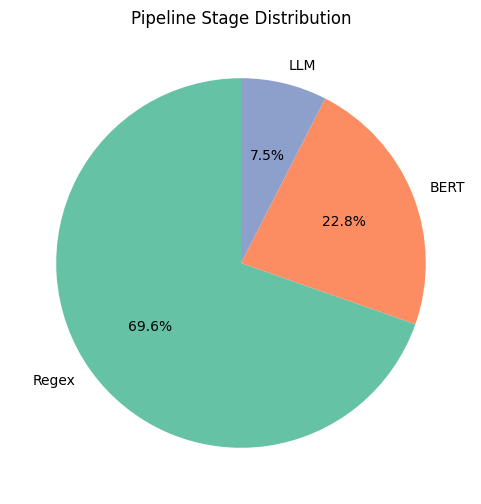

In [7]:
# 1. Pipeline Stage Distribution
stage_counts = df_classified['pipeline_stage'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(stage_counts, labels=stage_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2"))
plt.title('Pipeline Stage Distribution')
plt.show()


/var/folders/nr/ws6w6tv95dn99f0y1flq3x5w0000gn/T/ipykernel_18184/1915055400.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cats.values, y=top_cats.index, palette="Blues_d")


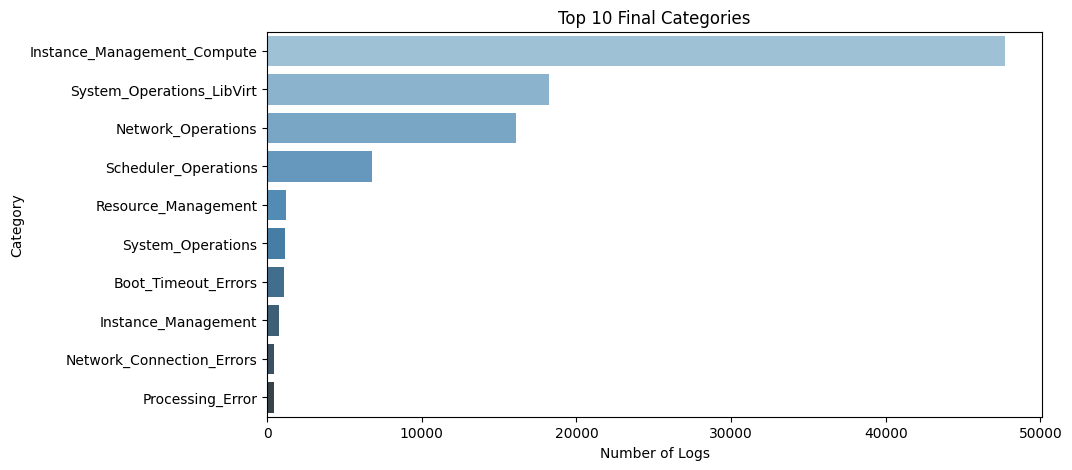

In [8]:
# 2. Top Final Categories
top_cats = df_classified['final_category'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_cats.values, y=top_cats.index, palette="Blues_d")
plt.title('Top 10 Final Categories')
plt.xlabel('Number of Logs')
plt.ylabel('Category')
plt.show()

In [9]:
# 3. Coverage and Unique Categories
total_logs = len(df_classified)
unique_categories = df_classified['final_category'].nunique()
print(f"Total logs classified: {total_logs}")
print(f"Unique final categories: {unique_categories}")


Total logs classified: 94749
Unique final categories: 14


In [10]:
# 4. Stage-wise Coverage
print("\nStage-wise coverage:")
for stage, count in stage_counts.items():
    print(f"{stage}: {count} logs ({count/total_logs*100:.1f}%)")



Stage-wise coverage:
Regex: 65975 logs (69.6%)
BERT: 21642 logs (22.8%)
LLM: 7132 logs (7.5%)


In [11]:
# 5. Category Distribution Table
print("\nTop 10 categories:")
print(top_cats)



Top 10 categories:
final_category
Instance_Management_Compute    47723
System_Operations_LibVirt      18252
Network_Operations             16058
Scheduler_Operations            6762
Resource_Management             1227
System_Operations               1150
Boot_Timeout_Errors             1067
Instance_Management              781
Network_Connection_Errors        446
Processing_Error                 431
Name: count, dtype: int64



Average confidence: 0.933


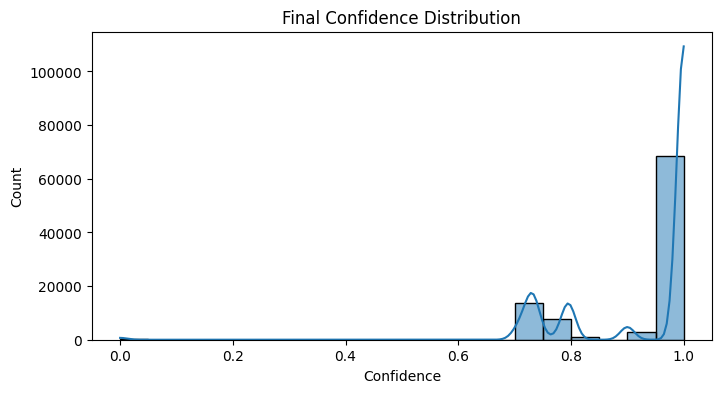

In [12]:
# 6. Optional: Confidence Analysis
if 'final_confidence' in df_classified.columns:
    avg_conf = df_classified['final_confidence'].mean()
    print(f"\nAverage confidence: {avg_conf:.3f}")
    plt.figure(figsize=(8,4))
    sns.histplot(df_classified['final_confidence'], bins=20, kde=True)
    plt.title('Final Confidence Distribution')
    plt.xlabel('Confidence')
    plt.show()